In [291]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
# import function to creat training and test set splits
# from sklearn.cross_validation import train_test_split
# import function to make prediction
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
import math

In [292]:
# read data from .csv file
# stock = pd.read_csv("./SYF.csv", skiprows = lambda x: x in [i for i in range(1,13)])
stock = pd.read_csv("./BAYZF.csv")
stock2 = stock.drop([i for i in range(1,13)])
for i in range(0,len(stock)):
    if stock['High'][i] == stock['Low'][i]:
        stock = stock.drop(i)
print(len(stock))
print(len(stock2))
close = list(stock['Close'])
high = list(stock['High'])
low = list(stock['Low'])
volume = list(stock['Volume'])
# print(volume)
stock.head()

1121
2475


,Date,Open,High,Low,Close,Adj Close,Volume
1,2/17/09,53.400002,53.400002,53.099998,53.200001,43.011486,400
2,2/18/09,53.400002,53.400002,53.299999,53.299999,43.092339,300
3,2/19/09,54.250000,54.250000,53.750000,53.750000,43.456146,500
4,2/20/09,52.299999,52.299999,51.900002,51.910000,41.968533,500
5,2/23/09,53.540001,53.540001,51.750000,52.000000,42.041302,1100


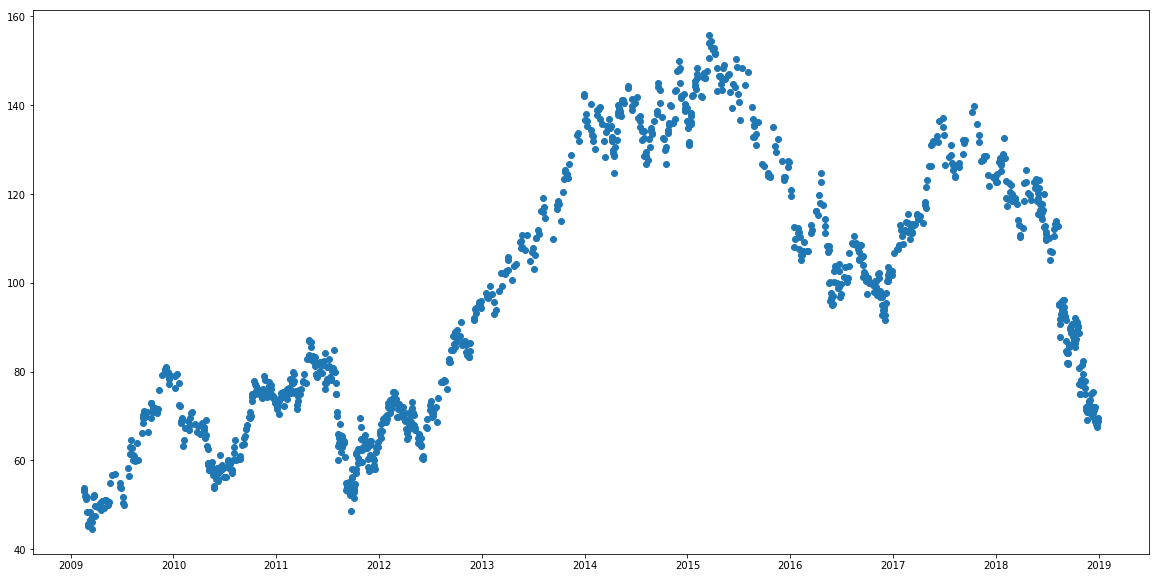

In [356]:
# plot the time-close price graph
time = stock['Date']
time_formatted = []
for index, i in enumerate(time):
    time_formatted.append(datetime.datetime.strptime(i, '%m/%d/%y')) 
dates = matplotlib.dates.date2num(time_formatted)
plt.figure(figsize=(20,10))
plt.plot_date(dates, close)

/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


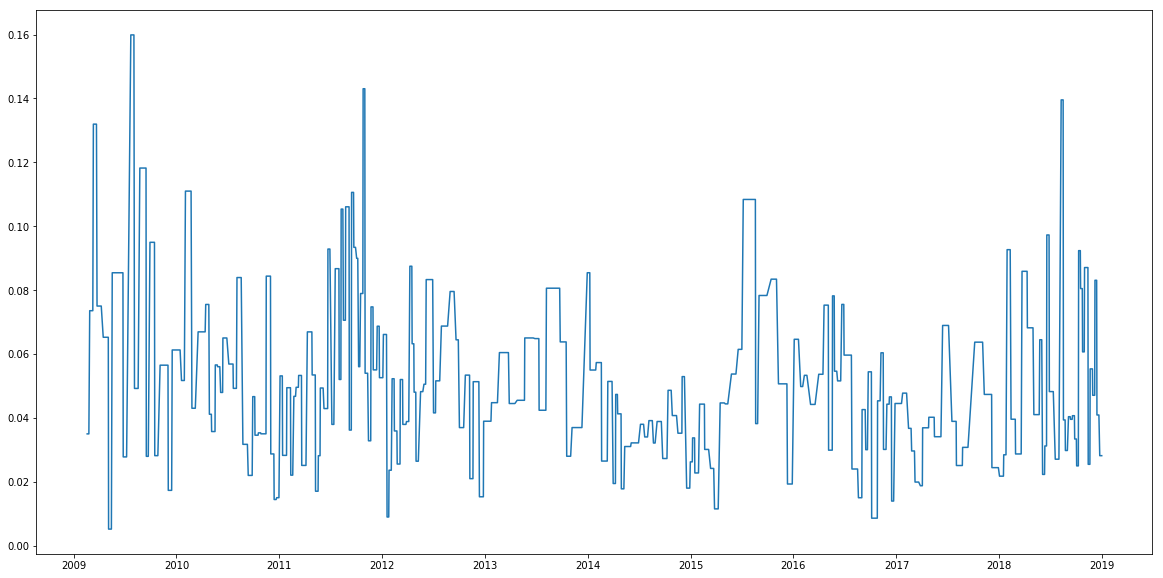

In [357]:
# calculate history volatility
base = [5, 20, 240] # weekly, monthly, annually
r_i = np.zeros((len(stock)-1, 1))
HV = np.zeros((len(stock)-1, len(base)))
HV2 = []
HV3 = []
for i in range(0, len(stock)-1):
    r_i[i] = np.log(close[i+1] / close[i])
for index, i in enumerate(base):
    round = (len(stock)-1)//i
    for j in range(0, round):
        r_tmp = r_i[j*i:(j+1)*i]
        r_std = np.std(r_tmp) * np.sqrt(i)
        if index==1:
            HV2.append(r_std)
        if index==2:
            HV3.append(r_std)
        for k in range(0, i):
            HV[j*i+k][index] = r_std
    r_tmp = r_i[round*i:len(stock)-1]
    r_std = np.std(r_tmp) * np.sqrt(i)
    if index==1:
            HV2.append(r_std)
    if index==2:
            HV3.append(r_std)
    for j in range(0, len(stock)-round*i-1):
        for k in range(round*i, len(stock)-1):
            HV[k][index] = r_std 
plt.figure(figsize=(20,10))
# plt.plot_date(dates, close,'.')
plt.plot_date(dates[1:len(dates)], HV[:,0],'-')
# plt.plot(time, close)

/usr/local/lib/python3.7/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


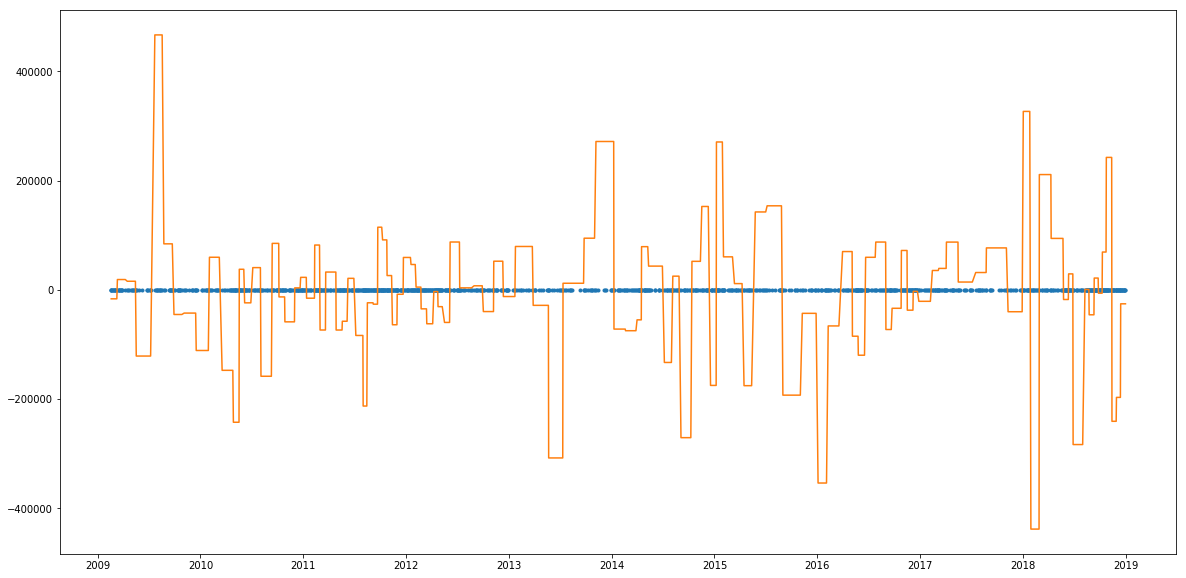

In [360]:
# calculate the ease of movement value(EMV)
#for 1 period of EMV
EMV = np.zeros((len(stock)-1, 1))
for i in range(0, len(stock)-1):
    dis_mov = (high[i+1] + low[i+1])/2 - (high[i] + low[i])/2
    box_ratio = (volume[i+1]/100000000)/(high[i+1] - low[i+1])
    EMV[i] = dis_mov/ box_ratio
# print(EMV)
#for N period of EMV
N = 10
EMV_N = np.zeros((len(stock)-1, 1))
EMV_10 = []
round = (len(stock)-1)//N
for i in range(0, round):
    EMV_tmp = EMV[i*N:(i+1)*N]
    EMV_avg = np.average(EMV_tmp)
    EMV_10.append(EMV_avg)
    for j in range(0, N):
        EMV_N[i*N+j] = EMV_avg
EMV_tmp = EMV[round*N:(len(stock)-1)]
EMV_avg = np.average(EMV_tmp)
for i in range(round*N, len(stock)-1):
    EMV_N[i] = EMV_avg
# print(EMV_N)

plt.figure(figsize=(20,10))
plt.plot_date(dates, close,'.')
plt.plot_date(dates[1:len(dates)], EMV_N,'-')

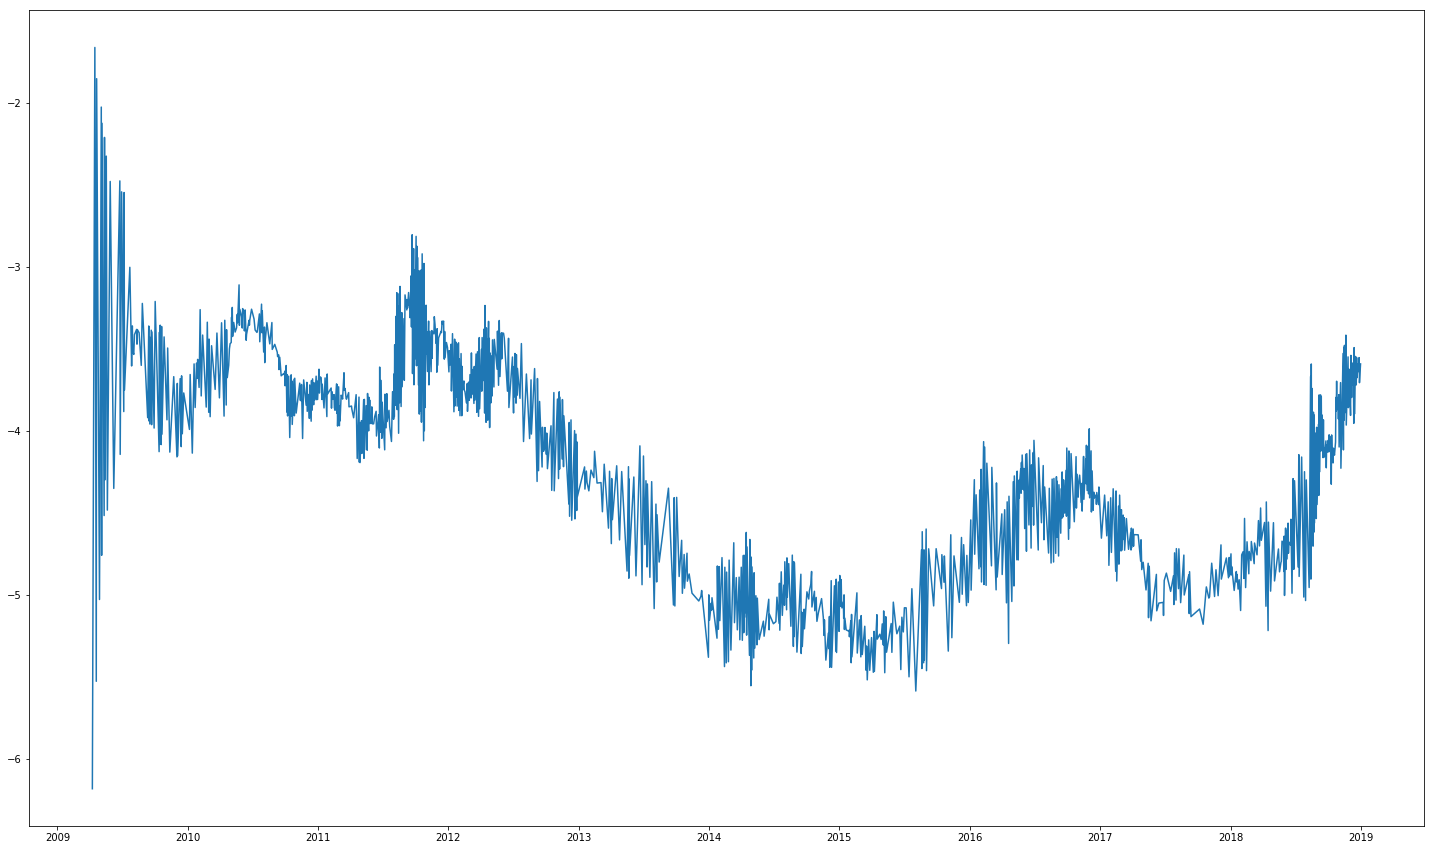

In [361]:
# calculate the exponential moving average(EMA)
base = [10, 30] # short and long period
EMA_N = np.zeros((len(stock), len(base)))
for index,i in enumerate(base):
    multiplier = 2 / (1 + i)
    round = (len(stock)-1)//i
    tmp = close[0:i]
    EMA_N[0][index] = np.average(tmp)
    for j in range(1, len(stock)):
        EMA_N[j][index] = (close[j]-EMA_N[j-1][index]) * multiplier / EMA_N[j-1][index]
plt.figure(figsize=(25,15))
# plt.plot_date(dates[1:len(dates)], close[1:len(dates)],'.')
plt.plot_date(dates[base[0]*2:len(dates)], EMA_N[base[0]*2:len(stock),0],'-')

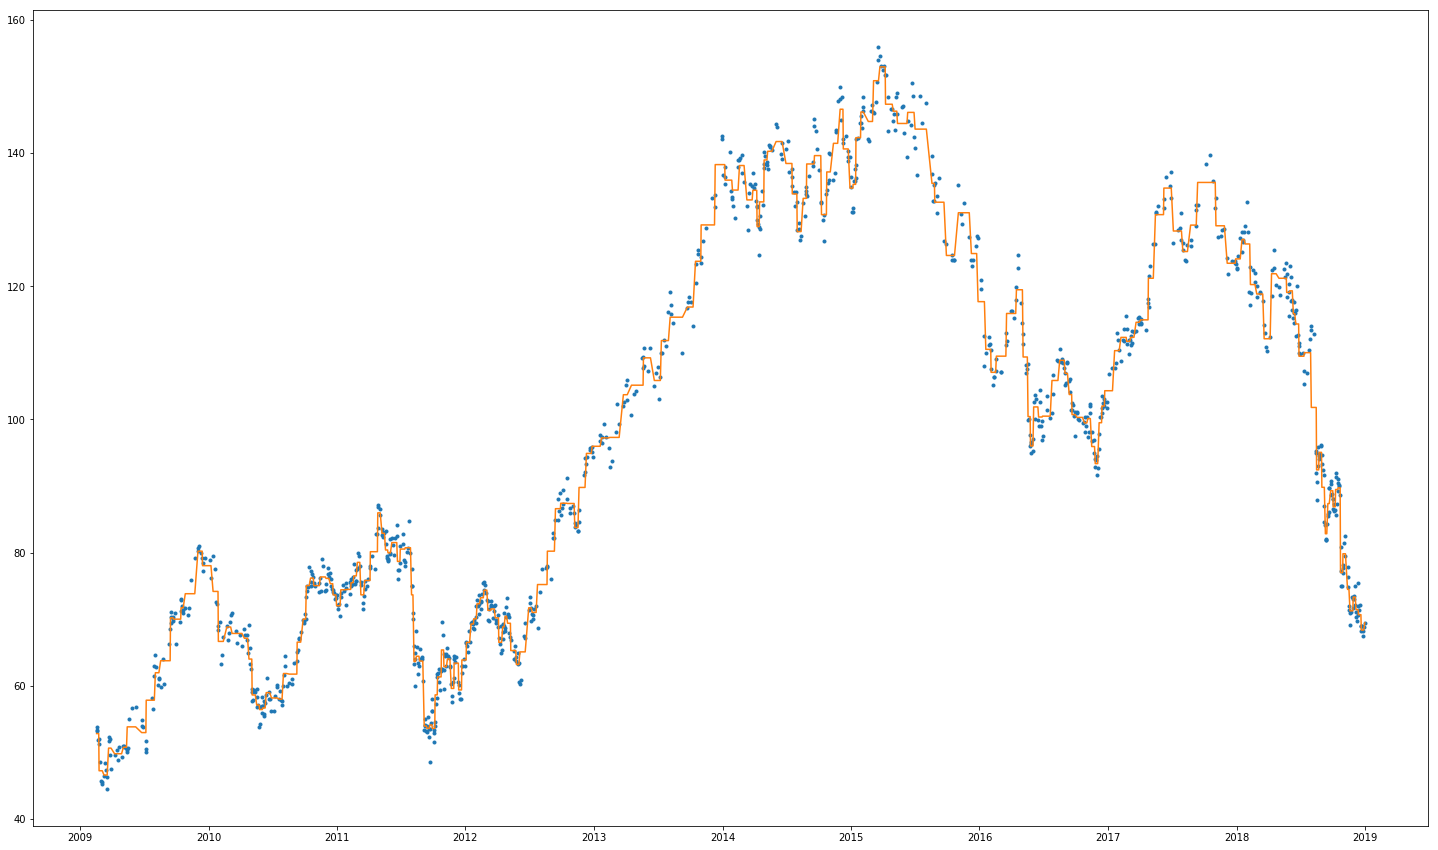

In [362]:
#calcualte the moving average(MA)
base = [5, 30]
MA_N = np.zeros((len(stock), len(base)))
MA1 = []
MA2 = []
for index,i in enumerate(base):
    round = len(stock)//i
    for j in range(0,round):
        tmp = close[j*i:(j+1)*i]
        if index==0:
            MA1.append(np.average(tmp))
        if index==1:
            MA2.append(np.average(tmp))     
        for k in range(0,i):
            MA_N[j*i+k][index] = np.average(tmp)
    tmp = close[round*i:len(stock)]
    if index==0:
            MA1.append(np.average(tmp))
    if index==1:
            MA2.append(np.average(tmp))  
    for j in range(round*i, len(stock)):
        MA_N[j][index] = np.average(tmp)
# print(MA_N[:,0])
plt.figure(figsize=(25,15))
plt.plot_date(dates, close,'.')
plt.plot_date(dates, MA_N[:,0],'-')

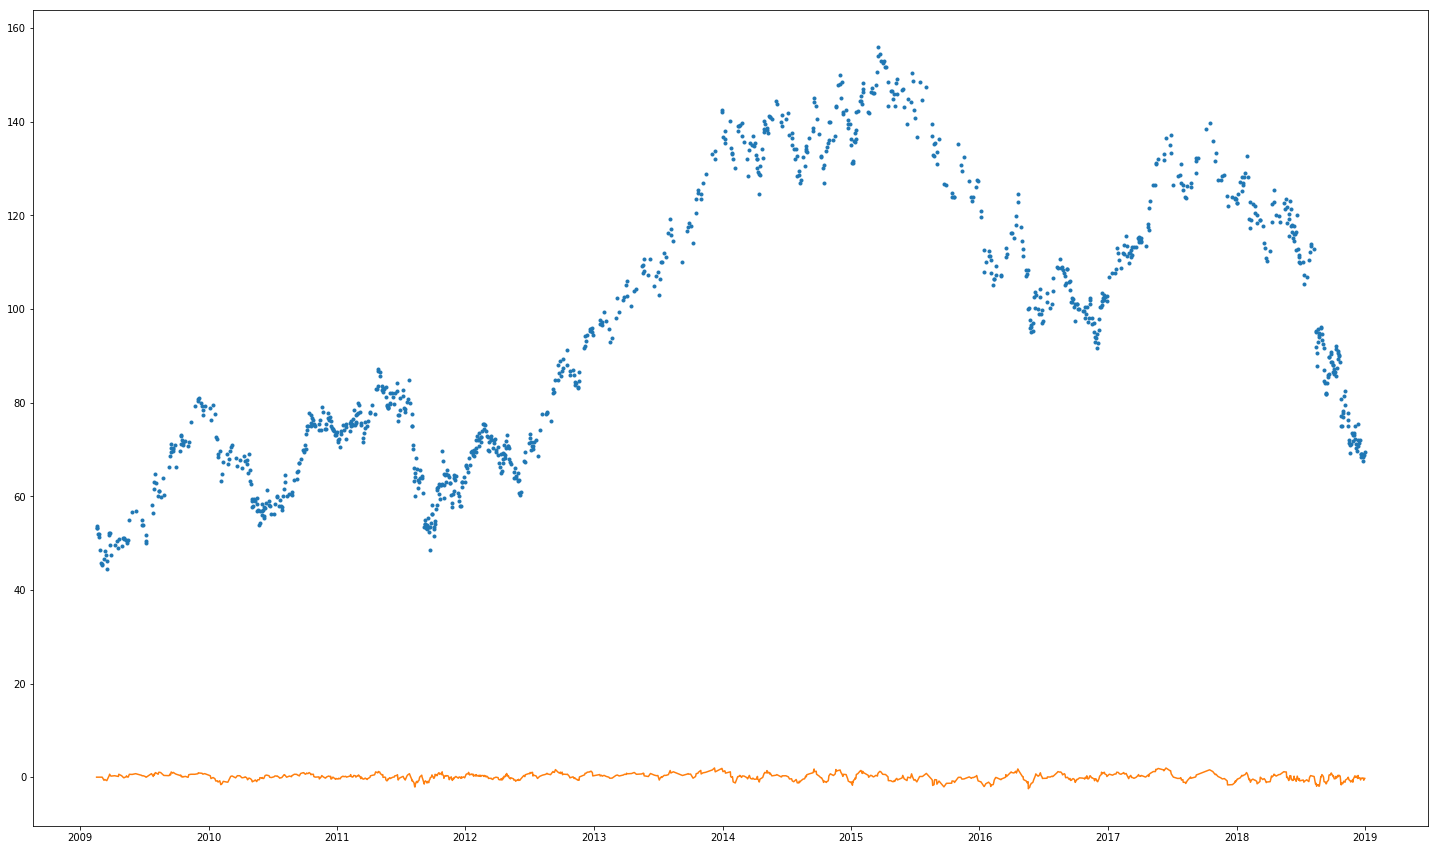

In [363]:
#calculate the MTM
N = 10 
MTM_N = np.zeros((len(stock), 1))
for i in range(N, len(stock)):
    MTM_N[i] = (close[i]-close[i-N])/N
plt.figure(figsize=(25,15))
plt.plot_date(dates, close,'.')
plt.plot_date(dates, MTM_N[:,0],'-')

In [364]:
# form input vector set for neural network
num_var = 10
input_vect = np.zeros((len(stock), num_var))
for i in range(0, len(stock)-1):
    input_vect[i+1][0] = HV[i][0]
    input_vect[i+1][1] = HV[i][1]
    input_vect[i+1][2] = HV[i][2]
    input_vect[i+1][3] = EMV[i]
    input_vect[i+1][4] = EMV_N[i]
    input_vect[i][5] = EMA_N[i][0]
    input_vect[i][6] = EMA_N[i][1]
    input_vect[i][7] = MA_N[i][0]
    input_vect[i][8] = MA_N[i][1]
    input_vect[i][9] = MTM_N[i]
    
input_vect[len(stock)-1][5] = EMA_N[len(stock)-1][0]
input_vect[len(stock)-1][6] = EMA_N[len(stock)-1][1]
input_vect[len(stock)-1][7] = MA_N[len(stock)-1][0]
input_vect[len(stock)-1][8] = MA_N[len(stock)-1][1]
input_vect[len(stock)-1][9] = MTM_N[len(stock)-1]

In [365]:
#split the trian test part
train = input_vect[10:int(len(input_vect)*0.8)]
train_label = np.array(close[10:int(len(input_vect)*0.8)])
train_label = train_label.reshape((len(train_label),1))
test = input_vect[int(len(input_vect)*0.8):len(input_vect)]
test_label = np.array(close[int(len(input_vect)*0.8):len(input_vect)])
test_label = test_label.reshape((len(test_label), 1))

In [366]:
#Placeholder
X = tf.placeholder(tf.float32, shape=[None, num_var])
Y = tf.placeholder(tf.float32, shape=[None,1])

In [367]:
# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [368]:
n_neurons_1 = 50
n_neurons_2 = 25
n_target = 1

#Layer 1
W_hidden_1 = tf.Variable(weight_initializer([num_var, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

#Layer 2
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

#Output Layer
W_out = tf.Variable(weight_initializer([n_neurons_2, n_target]))
bias_out = tf.Variable(bias_initializer([n_target]))

In [369]:
# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))

# Output layer (must be transposed)
out = tf.transpose(tf.add(tf.matmul(hidden_2, W_out), bias_out))


In [370]:
# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))
# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

453270.7


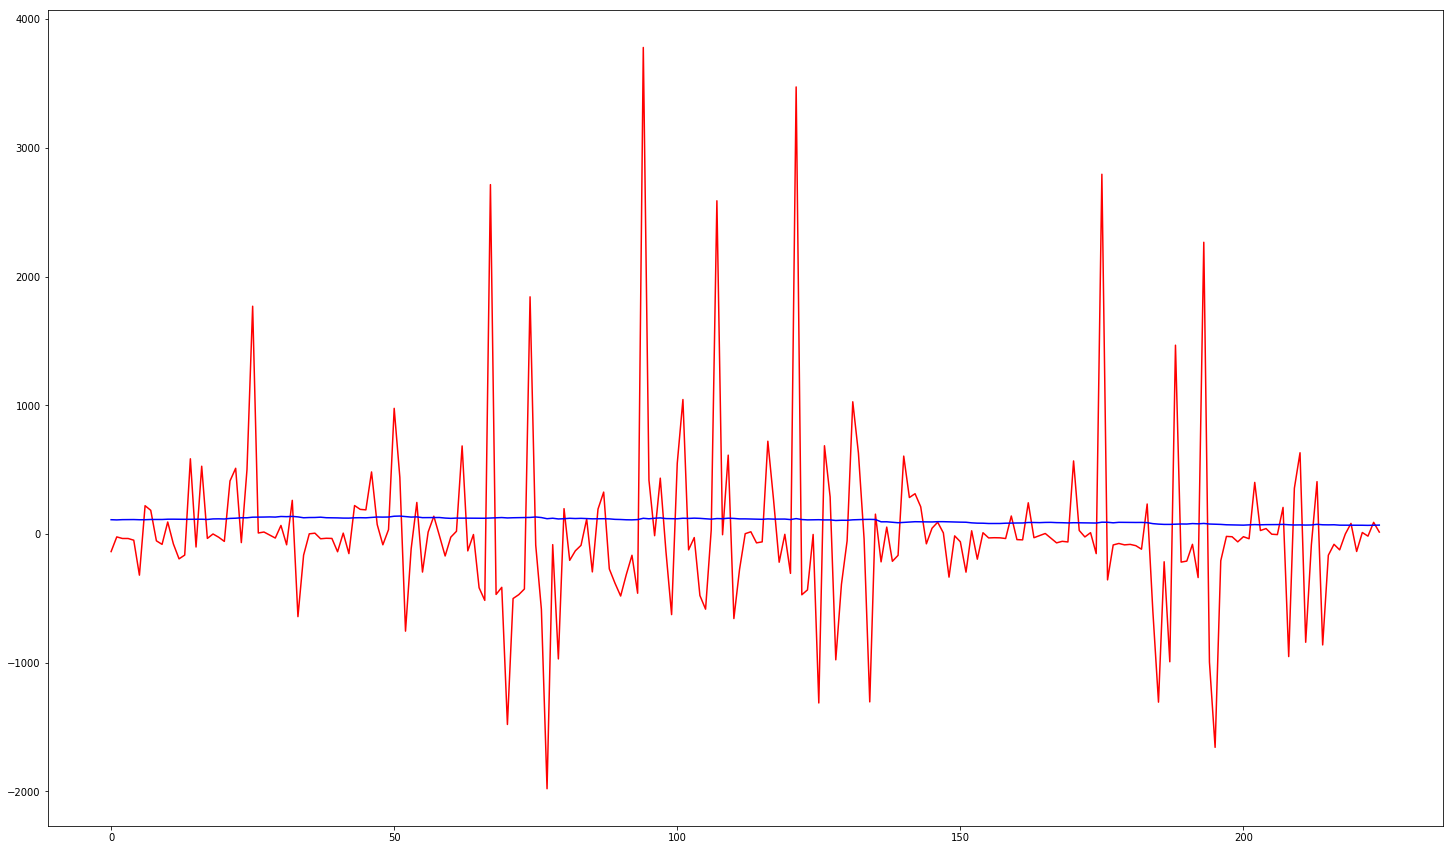

In [447]:
X_test = test
y_test = test_label

# Make Session
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Number of epochs and batch size
epochs = 40
batch_size = 16

X_train = train
y_train = train_label

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

# Print final MSE after Training
mse_final = net.run(mse, feed_dict={X: X_test, Y: y_test})
print(mse_final)
result = net.run(out, feed_dict={X: X_test, Y: y_test})
result = result.transpose()
# result = result.reshape((len(result), 1))
# print(result.shape)
# print(y_test)
plt.figure(figsize=(25,15))
plt.plot(result,'r')
plt.plot(y_test,'b')
plt.show()

In [339]:
true = [24.27, 24.09, 25.24, 25.37, 25.42, 25.99, 25.75, 26.02,
       25.85, 25.77, 26.38, 26.35, 26.28, 26.55, 29.4, 29.81, 29.79,
       29.98, 29.65, 30.07, 30.04, 29.69, 29.72, 29.99, 30.11, 30.11,
       29.94, 30.37, 30.44, 30.77, 30.83, 31.75]

In [437]:
#HV * 3
#EMV
#EMV_N
#EMA_N * 2
#MA * 2
#MTM * N

#make prediction of HV, EMV, EMV_N, EMA_N, MA, MTM using non-linear regression
base = [5, 20, 240] # weekly, monthly, annually
HV_pred = np.zeros((len(true),len(base)))
#for base = 5 (weekly)
HV_tmp = list(HV[-10:,0])
for i in range(0,len(true)):
#     HV_new = np.average(HV_tmp)
    HV_pred[i][0] = HV_new
    HV_pred[i][0] = HV_tmp[0]
    HV_tmp = HV_tmp[-9:]
    HV_tmp.append(HV_new)
#     HV_tmp.append(HV_tmp[0])
#for base = 20 (monthly)
HV_tmp = HV2[-12:-1]
print(HV_tmp)
for i in range(0,12):
    HV_pred[i][1] = np.average(HV_tmp)
    HV_tmp.append(np.average(HV_tmp))
    HV_tmp = HV_tmp[-12:]
for i in range(12, len(true)):
    HV_pred[i][1] = np.average(HV_tmp)
#for base=240 (yearly)
for i in range(0, len(true)):
    HV_pred[i][2] = np.average(HV3)
    
print(HV_pred[:,1])

[0.06476495811297597, 0.09338907997514691, 0.09563692680245978, 0.11669128810415419, 0.12714852970880133, 0.12660202404449422, 0.1957026571343187, 0.08966289636924324, 0.14010921740818633, 0.12870475279213395, 0.11160730876427889]
[0.11727451 0.11727451 0.12165031 0.12400541 0.12636945 0.12717597
 0.12717825 0.12722627 0.1215199  0.12417466 0.12284678 0.12235861
 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455
 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455
 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455 0.12325455
 0.12325455 0.12325455]


In [430]:
#for EMV
EMV_pred = np.zeros((len(true), 1))
EMV_tmp = list(EMV[-10:,0])
for i in range(0, len(true)):
#     EMV_new = np.average(EMV_tmp)
#     EMV_pred[i][0] = EMV_new
    EMV_pred[i][0] = EMV_tmp[0]
    EMV_tmp = EMV_tmp[-9:]
    EMV_tmp.append(EMV_tmp[0])
#for EMV_N
EMV_N_pred = np.zeros((len(true), 1))
EMV_N_tmp = EMV_10[-10:]
for i in range(0,3):
#     EMV_N_new = np.average(EMV_N_tmp)
    EMV_N_new = np.average(EMV_N_tmp[0])
    for j in range(0, 10):
        EMV_N_pred[i*10+j] = EMV_N_new
    EMV_N_tmp.append(EMV_N_new)
    EMV_N_tmp = EMV_N_tmp[-10:]
EMV_N_pred[30] = EMV_N_pred[29]
EMV_N_pred[31] = EMV_N_pred[30] 

In [431]:
#for EMA_1
EMA_pred = np.zeros((len(true), 2))
EMA_tmp = list(EMA_N[-300:,0])
for i in range(0, len(true)):
    EMA_new = np.average(EMA_tmp)
#     EMA_new = EMA_tmp[0]
    EMA_pred[i][0] = EMA_new
    EMA_tmp.append(EMA_new)
    EMA_tmp = EMA_tmp[-300:]
#for EMA_2   
EMA_tmp = list(EMA_N[-300:,1])
for i in range(0, len(true)):
    EMA_tmp = list(EMA_tmp)
    EMA_new = np.average(EMA_tmp)
#     EMA_new = EMA_tmp[0]
    EMA_pred[i][1] = EMA_new
    EMA_tmp.append(EMA_new)
    EMA_tmp = EMA_tmp[-300:]

In [432]:
#for MA
MA_pred = np.zeros((len(true), 2))
MA1_tmp = MA1[-5:]
MA2_tmp = MA2[-10:]
for i in range(0, len(true)//5):
    MA_new = np.average(MA1_tmp)
#     MA_new = MA1_tmp[0]
    for j in range(0, 5):
        MA_pred[j+i*5][0] = MA_new
    MA1_tmp.append(MA_new)
    MA1_tmp = MA1_tmp[-5:]
MA_pred[30][0] = MA_pred[29][0]
MA_pred[31][0] = MA_pred[29][0]

MA_new = MA2_tmp[0]
for j in range(0, len(true)):
    MA_pred[j][1] = MA_new

In [433]:
#for MTM
MTM_pred = np.zeros((len(true), 1))
MTM_tmp = list(MTM_N[-30:-1])
for i in range(0, len(true)):
    MTM_new = np.average(MTM_tmp)
#     MTM_new = MTM_tmp[0]
    MTM_pred[i] = MTM_new
    MTM_tmp.append(MTM_new)
    MTM_tmp = MTM_tmp[-15:]

In [434]:
# form input vector set for neural network
num_var = 10
test_vect = np.zeros((len(true), num_var))
for i in range(0, len(true)):
    test_vect[i][0] = HV_pred[i][0]
    test_vect[i][1] = HV_pred[i][1]
    test_vect[i][2] = HV_pred[i][2]
    test_vect[i][3] = EMV_pred[i]
    test_vect[i][4] = EMV_N_pred[i]
    test_vect[i][5] = EMA_pred[i][0]
    test_vect[i][6] = EMA_pred[i][1]
    test_vect[i][7] = MA_pred[i][0]
    test_vect[i][8] = MA_pred[i][1]
    test_vect[i][9] = MTM_pred[i]

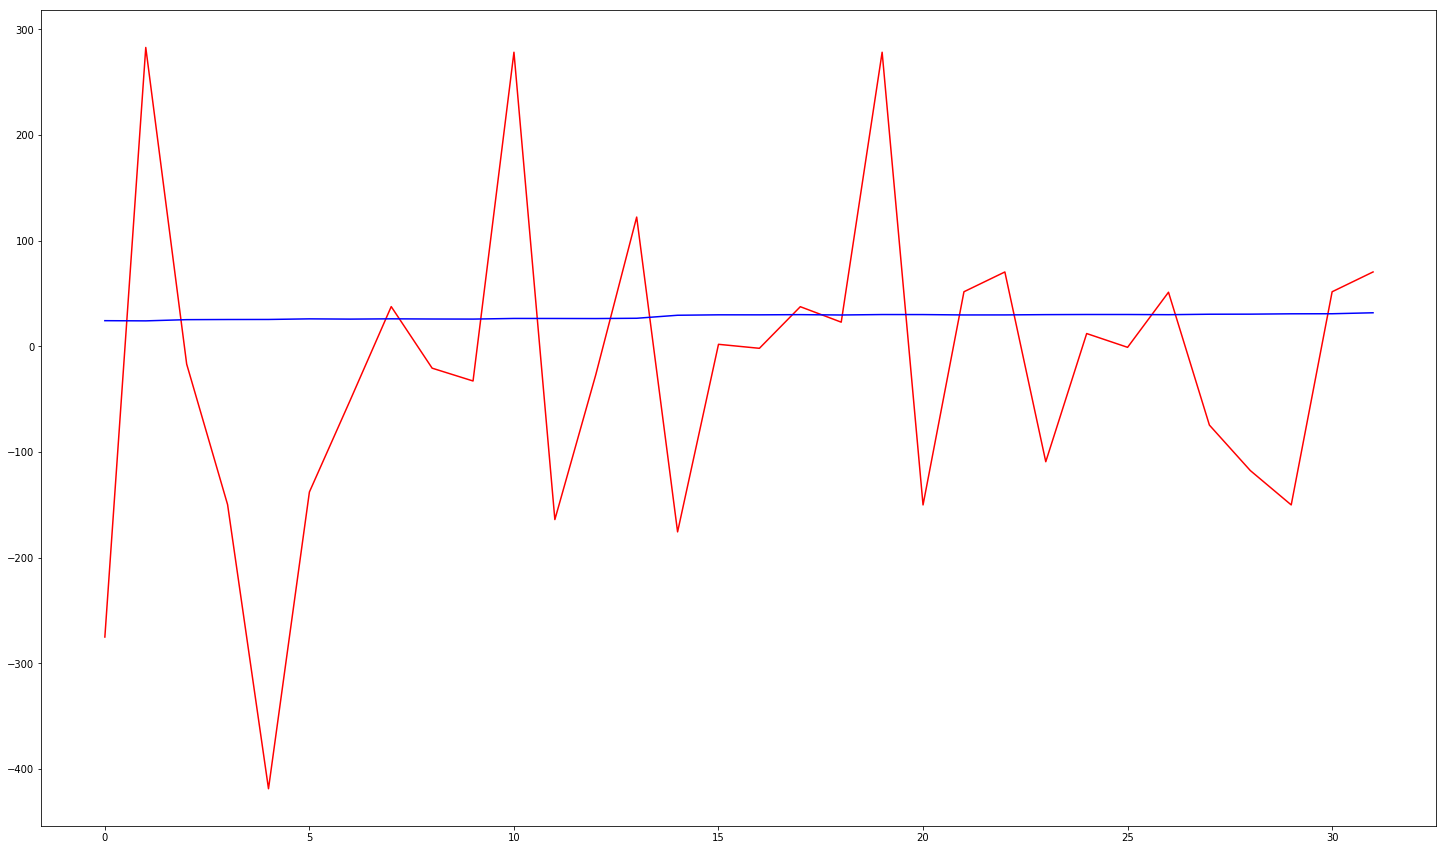

In [448]:
# print(mse_final)
pred = net.run(out, feed_dict={X: test_vect})
pred = pred.transpose()
# print(pred)
plt.figure(figsize=(25,15))
plt.plot(pred,'r')
plt.plot(true,'b')
plt.show()

In [449]:
for i in pred:
    print(int(i))

-275
282
-16
-149
-418
-137
-50
37
-20
-32
278
-163
-26
122
-175
1
-1
37
22
278
-150
51
70
-109
12
0
51
-74
-117
-150
51
70
